In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from itertools import product
from scipy.optimize import minimize

segment_count_beam = 50
vertical_level_count = 3
length_beam = 1000 # mm
youngs_modulus = 2e3 # MPa
moment_of_inertia = 20 # mm^4
channel_width_half = 10 # mm
E_list = []
F_list = []
u_list = []

if vertical_level_count % 2 == 0:
    vertical_level_count += 1

if segment_count_beam > length_beam/(2*channel_width_half):
    previous = segment_count_beam
    segment_count_beam = int(length_beam/(2*channel_width_half))

y_levels = np.linspace(-channel_width_half, channel_width_half, vertical_level_count)
s, ds = np.linspace(0, length_beam, segment_count_beam+1, retstep=True)

def segment_energy_functional(I_val, J_val, K_val, horizontal_force):
    theta1 = np.arcsin((J_val - I_val) / ds)
    theta2 = np.arcsin((K_val - J_val) / ds)

    internal_strain_energy = 0.5 * youngs_modulus * moment_of_inertia * ( (theta2 - theta1)/ds )**2 * ds
    external_force_work = horizontal_force * np.cos(theta1) * ds
    
    return internal_strain_energy + external_force_work

def viterbi_algorithm(vertical_level_count, segment_count_beam, segment_energy_functional, horizontal_force):
    C = {}
    survivor = {}
    index_zero = vertical_level_count//2

    for I, J in product(range(vertical_level_count), repeat=2):
        if I == index_zero:
            C[(I, J, 1)] = 0
            survivor[(I, J, 1)] = None
        else:
            C[(I, J, 1)] = np.inf
            survivor[(I, J, 1)] = None

    for m in range(2, segment_count_beam + 1):
        for J, K in product(range(vertical_level_count), repeat=2):
            best_cost = np.inf
            best_prev_I = None

            for I in range(vertical_level_count):
                prev_state_key = (I, J, m - 1)
                prev_cost = C.get(prev_state_key, np.inf)

                if prev_cost == np.inf:
                    continue

                trans_cost = segment_energy_functional(y_levels[I], y_levels[J], y_levels[K], horizontal_force)
                total_cost = prev_cost + trans_cost

                if total_cost < best_cost:
                    best_cost = total_cost
                    best_prev_I = I

            C[(J, K, m)] = best_cost
            survivor[(J, K, m)] = best_prev_I

    min_cost = np.inf
    best_final_key = None

    for J, K in product(range(vertical_level_count), repeat=2):
        current_key = (J, K, segment_count_beam)
        cost = C.get(current_key, np.inf)
        if cost < min_cost and K == index_zero:
            min_cost = cost
            best_final_key = current_key

    if best_final_key is None or min_cost == np.inf:
        print("No valid path found (possibly all paths lead to infinite cost).")
        return []
    else:
        path_indices = []
        current_J, current_K, current_m = best_final_key

        path_indices.append(current_K)
        path_indices.append(current_J)

        for m_step in range(segment_count_beam, 1, -1):
            prev_I = survivor[(current_J, current_K, m_step)]
            if prev_I is None:
                break
            path_indices.append(prev_I)
            current_K = current_J 
            current_J = prev_I


        final_J, final_K, _ = best_final_key
        reconstructed_y_indices = [final_K]
        reconstructed_y_indices.append(final_J)

        current_J_trace = final_J
        current_K_trace = final_K

        for m_trace in range(segment_count_beam, 1, -1):
            prev_I_trace = survivor[(current_J_trace, current_K_trace, m_trace)]
            if prev_I_trace is None:
                break
            reconstructed_y_indices.append(prev_I_trace)
            current_K_trace = current_J_trace
            current_J_trace = prev_I_trace

        reconstructed_y_indices.reverse()
        y_viterbi = [y_levels[i] for i in reconstructed_y_indices]
        return y_viterbi

def x_from_y(y):
    dy = np.diff(y)
    dx = np.sqrt(ds**2 - dy**2)
    x = np.cumulative_sum(dx, include_initial=True)
    return x

def energy_functional(y, horizontal_force):
    theta = np.arcsin(np.diff(y)/ds)
    diffs = np.diff(theta)
    v = 0.5 * youngs_modulus * moment_of_inertia * np.sum( (diffs/ds)**2 ) * ds + horizontal_force * np.sum(np.cos(theta)) * ds
    return v

def create_parameters_display(horizontal_force, x_minimized):   
    header = f'{"PARAMETER":<25}  {"VALUE":<10}  {"UNIT":<10}'

    parameters_data = [
        ("Beam Segment Count", segment_count_beam, ""),
        ("Vertical Level Count", vertical_level_count, ""),
        ("Beam Length", length_beam, "mm"),
        ("Horizontal Force", round(horizontal_force,2), "N"),
        ("Young's Modulus", youngs_modulus, "MPa"),
        ("Moment of Inertia", moment_of_inertia, "mm^4"),
        ("Channel Half-Width", channel_width_half, "mm"),
        ("Beam End x-Displacement", f"{x_minimized[-1]-length_beam:.1f}", "mm"),
    ]

    body_lines = []
    for name, value, unit in parameters_data:
        value_str = str(value)
        body_lines.append(f"{name:<25}  {value_str:<10}  {unit:<10}")

    solver_params_string = "\n".join([header, *body_lines])

    return solver_params_string

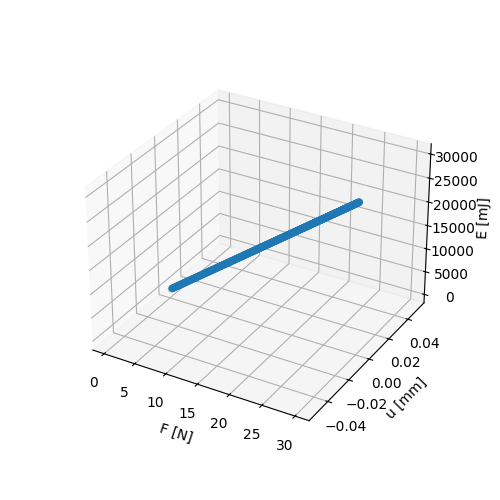

In [6]:
%matplotlib widget

force_values = np.arange(0.3, 30, 0.05)


for horizontal_force in force_values:  
    y_viterbi = viterbi_algorithm(vertical_level_count, segment_count_beam, segment_energy_functional, horizontal_force)
    x_viterbi = x_from_y(y_viterbi)

    res = minimize( energy_functional, 
                    x0=y_viterbi, 
                    constraints = [{"type": "eq", "fun": lambda y: y[-1]},
                                {"type": "eq", "fun": lambda y: y[0]}],
                    bounds = [(-channel_width_half, channel_width_half)
                            for _ in range(segment_count_beam+1)],
                    method="SLSQP",
                    args=(horizontal_force)
                    )

    y_minimized = res.x
    x_minimized = x_from_y(y_minimized)

    E_list.append(res.fun)
    F_list.append(horizontal_force)
    u_list.append(x_minimized[-1]-length_beam)

# E, F, u
 
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')

ax.scatter(F_list, u_list, E_list)

ax.set_xlabel('F [N]')
ax.set_ylabel('u [mm]')
ax.set_zlabel('E [mJ]')

plt.show()

In [7]:
import numpy as np
np.savez('graph_data.npz', F=F_list, u=u_list, E=E_list)

In [15]:
import numpy as np

# Load the .npz file
# The loaded object is a NumPy NpzFile object, which behaves like a dictionary.
loaded_data = np.load('graph_data.npz')

# You can see what arrays are stored inside by checking the .files attribute
print("Arrays stored in .npz file:", loaded_data.files) # This will print ['F', 'u', 'E']

# Access the individual arrays using their names (the keywords you provided during saving)
F_loaded = loaded_data['F']
u_loaded = loaded_data['u']
E_loaded = loaded_data['E']

print("\nLoaded F data:", F_loaded)
print("Loaded u data:", u_loaded)
print("Loaded E data:", E_loaded)

# IMPORTANT: Close the NpzFile object when you're done with it
# This is good practice, especially when dealing with many files or large files.
loaded_data.close()

Arrays stored in .npz file: ['F', 'u', 'E']

Loaded F data: [ 0.3   0.35  0.4   0.45  0.5   0.55  0.6   0.65  0.7   0.75  0.8   0.85
  0.9   0.95  1.    1.05  1.1   1.15  1.2   1.25  1.3   1.35  1.4   1.45
  1.5   1.55  1.6   1.65  1.7   1.75  1.8   1.85  1.9   1.95  2.    2.05
  2.1   2.15  2.2   2.25  2.3   2.35  2.4   2.45  2.5   2.55  2.6   2.65
  2.7   2.75  2.8   2.85  2.9   2.95  3.    3.05  3.1   3.15  3.2   3.25
  3.3   3.35  3.4   3.45  3.5   3.55  3.6   3.65  3.7   3.75  3.8   3.85
  3.9   3.95  4.    4.05  4.1   4.15  4.2   4.25  4.3   4.35  4.4   4.45
  4.5   4.55  4.6   4.65  4.7   4.75  4.8   4.85  4.9   4.95  5.    5.05
  5.1   5.15  5.2   5.25  5.3   5.35  5.4   5.45  5.5   5.55  5.6   5.65
  5.7   5.75  5.8   5.85  5.9   5.95  6.    6.05  6.1   6.15  6.2   6.25
  6.3   6.35  6.4   6.45  6.5   6.55  6.6   6.65  6.7   6.75  6.8   6.85
  6.9   6.95  7.    7.05  7.1   7.15  7.2   7.25  7.3   7.35  7.4   7.45
  7.5   7.55  7.6   7.65  7.7   7.75  7.8   7.85  7.9   7.95  8.

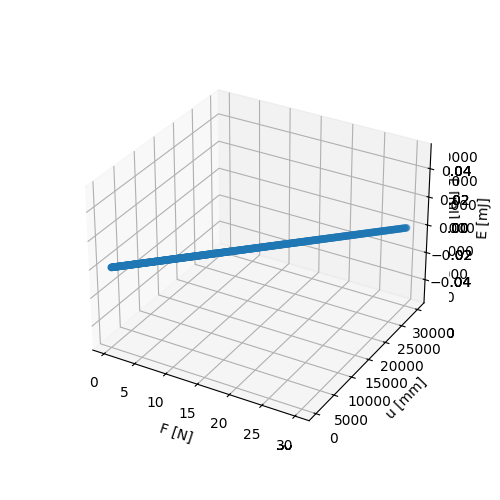

In [17]:
ax = fig.add_subplot(projection='3d')

ax.scatter(F_loaded, E_loaded, u_loaded)
ax.set_xlabel('F [N]')
ax.set_ylabel('u [mm]')
ax.set_zlabel('E [mJ]')

plt.show()

gradient method,
steepest descent method,
genetic algorithm